In [5]:
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import Word2Vec
from gensim.models import word2vec
from rdkit import Chem
import pandas as pd
import numpy as np
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import deepchem as dc
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from deepchem.data.datasets import NumpyDataset


In [6]:
"""
SIDER dataset loader.
"""
from __future__ import division
from __future__ import unicode_literals

import os
import logging
import deepchem

logger = logging.getLogger(__name__)


def load_sider_for_mol2vec(featurizer='ECFP', split='index', reload=True, K=4):
  """Load MUV datasets. Does not do train/test split"""
  # Load Sider dataset
  logger.info("About to load Sider dataset.")
  data_dir = deepchem.utils.get_data_dir()
  if reload:
    save_dir = os.path.join(data_dir, "sider/" + featurizer + "/" + str(split))

  #dataset_file = os.path.join(data_dir, "muv.csv.gz")
  dataset_file = os.path.join("/home/mamonteiro/source-code/Project-LEI/sider/", "sider.csv.gz")
  #if not os.path.exists(dataset_file):
  #  deepchem.utils.download_url(
  #      'http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/muv.csv.gz'
  #  )

  SIDER_tasks = sorted([ 'Hepatobiliary disorders',
       'Metabolism and nutrition disorders', 'Product issues', 'Eye disorders',
       'Investigations', 'Musculoskeletal and connective tissue disorders',
       'Gastrointestinal disorders', 'Social circumstances',
       'Immune system disorders', 'Reproductive system and breast disorders',
       'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
       'General disorders and administration site conditions',
       'Endocrine disorders', 'Surgical and medical procedures',
       'Vascular disorders', 'Blood and lymphatic system disorders',
       'Skin and subcutaneous tissue disorders',
       'Congenital, familial and genetic disorders',
       'Infections and infestations',
       'Respiratory, thoracic and mediastinal disorders',
       'Psychiatric disorders', 'Renal and urinary disorders',
       'Pregnancy, puerperium and perinatal conditions',
       'Ear and labyrinth disorders', 'Cardiac disorders',
       'Nervous system disorders',
       'Injury, poisoning and procedural complications'
  ])

  if reload:
    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_dir)
    if loaded:
      return SIDER_tasks, all_dataset, transformers

  # Featurize MUV dataset
  logger.info("About to featurize MUV dataset.")

  if featurizer == 'ECFP':
    featurizer = deepchem.feat.CircularFingerprint(size=1024)
  elif featurizer == 'GraphConv':
    featurizer = deepchem.feat.ConvMolFeaturizer()
  elif featurizer == 'Weave':
    featurizer = deepchem.feat.WeaveFeaturizer()
  elif featurizer == 'Raw':
    featurizer = deepchem.feat.RawFeaturizer()

  loader = deepchem.data.CSVLoader(
      tasks=SIDER_tasks, smiles_field="smiles", featurizer=featurizer)
  dataset = loader.featurize(dataset_file)

  # Initialize transformers
  transformers = [
      deepchem.trans.BalancingTransformer(transform_w=True, dataset=dataset)
  ]
  logger.info("About to transform data")
  for transformer in transformers:
    dataset = transformer.transform(dataset)

  if split == None:
    return SIDER_tasks, (dataset, None, None), transformers

  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'scaffold': deepchem.splits.ScaffoldSplitter(),
      'task': deepchem.splits.TaskSplitter()
  }
  splitter = splitters[split]
  if split == 'task':
    fold_datasets = splitter.k_fold_split(dataset, K)
    all_dataset = fold_datasets
  else:
    train, valid, test = splitter.train_valid_test_split(dataset)
    all_dataset = (train, valid, test)
    if reload:
      deepchem.utils.save.save_dataset_to_disk(save_dir, train, valid, test,
                                               transformers)
  return SIDER_tasks, all_dataset, transformers


In [8]:
tasks, datasets, transformers = load_sider_for_mol2vec()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids
test_smiles = test_dataset.ids

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [9]:
len(train_dataset)

1141

In [10]:
train_dataset.ids

array(['C(CNCCNCCNCCN)N',
       'CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=O)O)C(C)(C)C',
       'CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O)CCC4=CCCC[C@H]34',
       ..., 'CC12CC(C3(C(C1CC(C2(C(=O)CO)O)O)CCC4=CC(=O)C=CC43C)F)O',
       'CC1=CC(=CC(=C1OC2=NC(=NC(=C2Br)N)NC3=CC=C(C=C3)C#N)C)C#N',
       'CC1=NN=C2N1C3=C(C=C(C=C3)Cl)C(=NC2)C4=CC=CC=C4Cl'], dtype=object)

In [13]:
# Get SMILES from file
def getSMILES(filepath):
    df = pd.read_csv(filepath)    
    smiles_df = df[['smiles']].dropna()
    return smiles_df

In [14]:
# Generate molecules from SMILES strings
def generateEmbeddings(smiles_df, trained_model):
    smiles = list(smiles_df['smiles'])
    smiles = [x.split(';')[0] for x in smiles]
    # SMILES to Mol
    molecules = [Chem.MolFromSmiles(x) for x in smiles]
    # Load previously trained mol2vec model
    model = Word2Vec.load(trained_model)
    # Convert molecules to sentences and then to embeddings
    sentences = [mol2alt_sentence(x, 1) for x in molecules]
    vectors = [DfVec(x) for x in sentences2vec(sentences, model, unseen='UNK')]
    vec_df = pd.DataFrame(data=np.array([x.vec for x in vectors]))
    vec_df.columns = ['mol2vec_' + str(x+1) for x in vec_df.columns.values]
    vec_df.index = smiles_df.index.values
    return pd.concat([smiles_df, vec_df], axis=1)

In [18]:
train_smiles_from_sider=pd.DataFrame(train_smiles_from_sider,  columns=['smiles'])
valid_smiles_from_sider=pd.DataFrame(valid_smiles_from_sider,  columns=['smiles'])
test_smiles_from_sider=pd.DataFrame(test_smiles_from_sider,  columns=['smiles'])

In [19]:
len(train_smiles_from_sider)

1141

In [20]:
import os
 
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : /home/mamonteiro/source-code/Project-LEI/sider
Directory name is : sider


In [22]:
#Estas 3 linhas deveriam ser feitas de outra maneira
#Deveriamos fazer o mesmo com o dataset completo mas neste momento vai ficar assim pelo receio que tenho de nao ter o dataset dividido como suposto

train_embeddings_generated_from_mol2vec = generateEmbeddings(train_smiles_from_sider, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')
valid_embeddings_generated_from_mol2vec = generateEmbeddings(valid_smiles_from_sider, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')
test_embeddings_generated_from_mol2vec = generateEmbeddings(test_smiles_from_sider, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')

In [23]:
train_embeddings_generated_from_mol2vec.head()

,smiles,mol2vec_1,mol2vec_2,mol2vec_3,mol2vec_4,mol2vec_5,mol2vec_6,mol2vec_7,mol2vec_8,mol2vec_9,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,C(CNCCNCCNCCN)N,-0.990727,-1.723967,1.596080,0.336589,5.995870,1.602312,-7.893780,-0.770941,2.798226,...,1.845091,4.080578,5.290233,2.681949,-6.017433,0.732134,-0.161610,-7.355957,-6.514126,-4.416229
1,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,0.596306,0.060384,-4.686247,4.381831,2.139633,-0.343262,-13.849467,0.780369,9.671047,...,-0.760953,9.614191,13.119958,-0.408570,-7.577562,-4.803534,-4.880173,-7.033062,-15.572207,-4.429869
2,CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...,1.854099,-4.819261,0.775984,3.286393,1.519570,-6.281527,-10.383826,5.000489,-0.742257,...,0.873612,15.422496,-1.348580,-1.571692,-17.224537,-6.963869,-12.192692,-3.912728,-8.017673,1.265650
3,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34,2.140168,-5.169839,-0.039611,3.000724,0.787211,-6.880911,-10.384640,5.767844,-0.478307,...,0.627151,15.921182,-1.159732,-1.260444,-17.655016,-7.629984,-13.157971,-3.574889,-8.912206,1.509292
4,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,-0.227203,-2.800524,-1.099674,4.259158,-1.261016,-2.570959,-8.051775,1.025365,6.135835,...,-0.972749,9.117423,7.184863,-0.012285,-7.312431,-1.483516,-4.117091,-2.378627,-9.008883,-0.717169


In [24]:
len(train_embeddings_generated_from_mol2vec),len(valid_embeddings_generated_from_mol2vec),len(test_embeddings_generated_from_mol2vec) 

(1141, 143, 143)

In [25]:
train_embeddings_generated_from_mol2vec.iloc[0][0]

'C(CNCCNCCNCCN)N'

In [29]:
import os
import deepchem as dc


#current_dir = os.path.dirname(os.path.realpath("__file__"))
#dataset_file = "medium_muv.csv.gz"


#dataset = dc.utils.save.load_from_disk('/home/mamonteiro/source-code/Project-LEI/SIDER/sider_embeddings.csv')
#print("Columns of dataset: %s" % str(dataset.columns.values))
#print("Number of examples in dataset: %s" % str(dataset.shape[0]))

The dataset that we must manipulate is thhe follwoing one: dataset

In this dataset has as columns the SMILES
                               The side efects
                               and finally the embeddings
        
We need to split this dataset in order to provide this data to multitask model

In [30]:
#dataset=dataset.drop(['smiles'], axis=1)

In [31]:
train_embeddings=train_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)
valid_embeddings=valid_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)
test_embeddings=test_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)

In [32]:
#sideEfects=
#dataset.iloc[:,0:27].head()

In [33]:
#sideEfects= dataset.iloc[:,0:27]

In [34]:
#sideEfects.head()

In [35]:
#dataset.iloc[:,27:]

In [36]:
#Retirar, nao esta aqui a fazer nada
#embeddings=dataset.iloc[:,27:]
#embeddings=dataset

In [37]:
train_embeddings.head()

,mol2vec_1,mol2vec_2,mol2vec_3,mol2vec_4,mol2vec_5,mol2vec_6,mol2vec_7,mol2vec_8,mol2vec_9,mol2vec_10,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,-0.990727,-1.723967,1.596080,0.336589,5.995870,1.602312,-7.893780,-0.770941,2.798226,-4.712134,...,1.845091,4.080578,5.290233,2.681949,-6.017433,0.732134,-0.161610,-7.355957,-6.514126,-4.416229
1,0.596306,0.060384,-4.686247,4.381831,2.139633,-0.343262,-13.849467,0.780369,9.671047,4.445226,...,-0.760953,9.614191,13.119958,-0.408570,-7.577562,-4.803534,-4.880173,-7.033062,-15.572207,-4.429869
2,1.854099,-4.819261,0.775984,3.286393,1.519570,-6.281527,-10.383826,5.000489,-0.742257,0.579260,...,0.873612,15.422496,-1.348580,-1.571692,-17.224537,-6.963869,-12.192692,-3.912728,-8.017673,1.265650
3,2.140168,-5.169839,-0.039611,3.000724,0.787211,-6.880911,-10.384640,5.767844,-0.478307,0.191780,...,0.627151,15.921182,-1.159732,-1.260444,-17.655016,-7.629984,-13.157971,-3.574889,-8.912206,1.509292
4,-0.227203,-2.800524,-1.099674,4.259158,-1.261016,-2.570959,-8.051775,1.025365,6.135835,2.401863,...,-0.972749,9.117423,7.184863,-0.012285,-7.312431,-1.483516,-4.117091,-2.378627,-9.008883,-0.717169


In [38]:
train_embeddings.isnull().any().any()

False

In [39]:
len(train_embeddings.columns)

300

In [40]:
len(train_embeddings)

1141

In [41]:
NCA1 = 100
NCA2 = 100
DROPRATE = 0.2
EP = 50
BATCH_SIZE = 128
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [42]:
# VERFICAR SE É NECESSÁRIO
from deepchem.data.datasets import NumpyDataset # import NumpyDataset

#NESTE MOMENTO NAO TENHO
#dataset_with_weights = NumpyDataset(sideEfects) # creates numpy dataset object


Iterating over NumpyDataset
¶
In order to iterate over NumpyDataset, we use itersamples method. 

We iterate over 4 quantities, namely X, y, w and ids. 

The first three quantities are the same as discussed above and ids is the id of the data instance. 

By default the id is given in order starting from 1


You can also extract the ids by dataset.ids. This would return a numpy array consisting of the ids of the data instances.

dataset.ids

In [43]:
#from deepchem.splits.splitters import IndexSplitter
#splitter=IndexSplitter()
#train_data,valid_data,test_data=splitter.split(dataset_with_weights,frac_train=0.7,frac_valid=0.2,frac_test=0.1)


In [44]:
#train_data=[i for i in train_data]
#valid_data=[i for i in valid_data]
#test_data=[i for i in test_data]

In [45]:
#len(train_data),len(valid_data),len(test_data)

In [46]:
#dataset_with_weights

In [60]:
train_embeddings_dataset = dc.data.NumpyDataset(train_embeddings,
                                                train_dataset.y,
                                                train_dataset.w,
                                                train_dataset.ids)

In [61]:
valid_embeddings_dataset = dc.data.NumpyDataset(valid_embeddings,
                                                valid_dataset.y,
                                                valid_dataset.w,
                                                valid_dataset.ids)

In [62]:
test_embeddings_dataset = dc.data.NumpyDataset(test_embeddings,
                                                test_dataset.y,
                                                test_dataset.w,
                                                test_dataset.ids)

In [63]:
nb_epochs=[50,100, 150, 200,250,300,400,500,1000,2000]
losses = []
loss =0

In [64]:
model = dc.models.MultitaskClassifier(n_tasks=27,
                                      n_features=300,
                                      layer_sizes=[512])

for epoch in nb_epochs :
    loss = model.fit(train_embeddings_dataset, epoch=epoch)
    print("Epoch %d loss: %f" % (epoch, loss))
    losses.append(loss)

Epoch 50 loss: 1737.725124
Epoch 100 loss: 1453.424212
Epoch 150 loss: 1421.950373
Epoch 200 loss: 1405.342041
Epoch 250 loss: 1374.143151
Epoch 300 loss: 1349.430269
Epoch 400 loss: 1333.241439
Epoch 500 loss: 1318.440115
Epoch 1000 loss: 1297.899559
Epoch 2000 loss: 1285.611590


<module 'matplotlib.pyplot' from '/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/matplotlib/pyplot.py'>

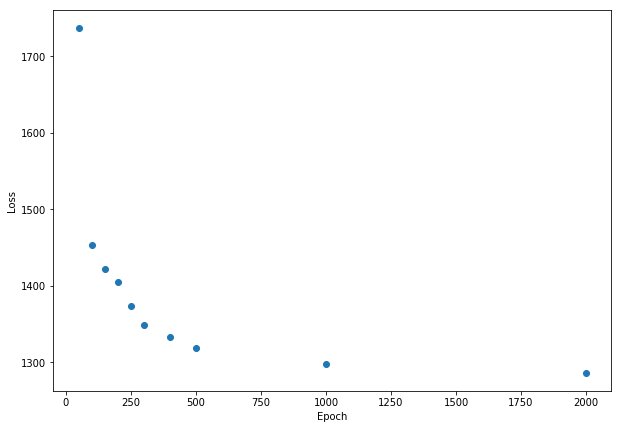

In [65]:
import matplotlib.pyplot as plot

plot.figure(figsize=(10,7))
plot.ylabel("Loss")
plot.xlabel("Epoch")
x = nb_epochs
y = losses
plot.scatter(x, y)
plot

In [66]:
import numpy as np
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")
train_score = model.evaluate(train_embeddings_dataset, [metric], transformers)
print('Training set ROC AUC:', train_score)


computed_metrics: [0.822452933222384, 0.8049625468164794, 0.7640212969008991, 0.7481329724003277, 0.8136128861162326, 0.7660784791937195, 0.8506078055022392, 0.7886930161439442, 0.8063647566235368, 0.752810599310425, 0.7387602103614188, 0.7250992885757702, 0.8042819019893257, 0.7530451634771973, 0.7624547216515798, 0.81972409600753, 0.869063995215311, 0.8268661518661519, 0.9678206210713951, 0.79383661686078, 0.7654532714957792, 0.781599862208115, 0.7719921164342025, 0.8230572028663208, 0.8009297287307227, 0.8023183584550164, 0.7847186370676303]
Training set ROC AUC: {'mean-roc_auc_score': 0.7966207124653494}


In [67]:
valid_score = model.evaluate(valid_embeddings_dataset, [metric], transformers)
print('Validation set ROC AUC:', valid_score)

computed_metrics: [0.6335723890632003, 0.6304347826086957, 0.5608899297423887, 0.587515299877601, 0.6043417366946778, 0.6265493802479007, 0.4795127353266888, 0.6439393939393939, 0.6730617088607594, 0.5518617021276596, 0.6474418604651162, 0.5594629156010229, 0.5740045078888054, 0.5928807166430929, 0.4649122807017544, 0.5968468468468469, 0.5896946564885497, 0.7201017811704835, 0.8943661971830986, 0.632093023255814, 0.5788102475032566, 0.6517119244391971, 0.5852671343766864, 0.642224409448819, 0.5847457627118644, 0.6211382113821138, 0.5327433628318584]
Validation set ROC AUC: {'mean-roc_auc_score': 0.6096342554602721}


In [68]:
test_score = model.evaluate(test_embeddings_dataset, [metric], transformers)
print('Validation set ROC AUC:', test_score)

computed_metrics: [0.6523405972558515, 0.5765199161425576, 0.5765639589169, 0.6547619047619049, 0.6732203389830509, 0.6594117647058824, 0.6053149606299213, 0.5505208333333333, 0.71875, 0.6081632653061224, 0.5979609929078014, 0.5488493269648285, 0.6869328493647913, 0.6519607843137254, 0.6555555555555556, 0.6720907297830375, 0.6333333333333333, 0.46018518518518514, 0.574468085106383, 0.7477203647416413, 0.7203182374541004, 0.6830985915492958, 0.6331918906176333, 0.7054154995331465, 0.6349206349206349, 0.5709617180205415, 0.5094295143800094]
Validation set ROC AUC: {'mean-roc_auc_score': 0.6282207716210062}



# Valores muito fracos - Melhorar ....